# HadISD Analysis

Author: Ilan Valencius

Institution: Boston College

Purpose: Analyze the Hadley Center Integrated Surface Dataset with a focus on wind properties

Created: 10-25-2023

## Download HadISD

Download links are extracted from the [Hadley Center Website](https://www.metoffice.gov.uk/hadobs/hadisd/v331_202309p/download.html) and stored in ```HadISD_download_links.txt```

In [ ]:
# ! sh /wind-analysis/download_HadISD.sh

## Library Imports for analysis

In [55]:
import os
from tqdm import tqdm, trange
# import sys
from glob import glob
# Better debugging printing
from icecream import ic
# Working with data
import xarray as xr
import numpy as np
import pandas as pd
import regionmask
from scipy.ndimage import shift # Shifts arrays
# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
# Parallel processing
from joblib import Parallel, delayed, parallel_config
# Working with geographic datatypes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Kriging the data
from pykrige.ok import OrdinaryKriging
# Plotting Options
import scienceplots
plt.style.use(["science", "nature"]) # Can also add the style: "grid"
# plt.rcParams.update({
#     "font.family": "sans serif",   # specify font family here
#     "font.serif": ["Helvetica"],  # specify font here
#     "font.size":11})          # specify font size here

# Merge HadISD Sites by US State

## Pipeline:
1. Load station metadata
2. Mask all stations by US state
3. For each state, load these files and combine into one netcdf file

In [26]:
# Variables commented out are KEPT
drop_vars = [
        'temperatures',
        'dewpoints',
        'slp',
        'stnlp',
        # 'windspeeds',
        # 'winddirs',
        'total_cloud_cover',
        'low_cloud_cover',
        'mid_cloud_cover',
        'high_cloud_cover',
        'precip1_depth',
        'precip2_depth',
        'precip3_depth',
        'precip6_depth',
        'precip9_depth',
        'precip12_depth',
        'precip15_depth',
        'precip18_depth',
        'precip24_depth',
        'cloud_base',
        # 'wind_gust',
        'past_sigwx1',
        'input_station_id',
        'quality_control_flags',
        'flagged_obs',
        'reporting_stats'
]

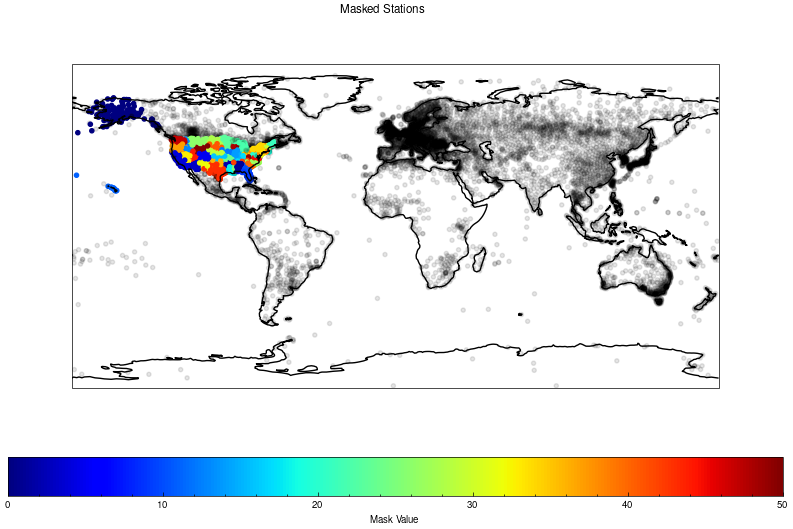

Masking States and Extracting Data: 100%|██████████| 51/51 [4:47:02<00:00, 337.69s/it]  


In [27]:
# Load station metadata
metadata = pd.read_table("../data/HadISD/hadisd_station_info_v331_202309p.txt", delim_whitespace=True, 
                         header=None, 
                         names=["station", "lat", "lon", "elevation [m]"])
# Coerce to xarray dataset for easy masking
stations_xr = xr.Dataset(
    data_vars=dict(
        lat=(["station"], metadata["lat"]),
        lon=(["station"], metadata["lon"]),
        elevation=(["station"], metadata["elevation [m]"])
    ),
    coords=dict(
        station=metadata["station"],
    )
)
# Load regionmask for US States
states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
# Mask states
states_mask = states.mask(stations_xr)

# Plot of all masked stations
fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={"projection":ccrs.PlateCarree()})
fig.suptitle("Masked Stations")
cmap = cm.jet
cmap.set_bad('black',0.1) # For stations that aren't masked
c = ax.scatter(stations_xr['lon'], stations_xr['lat'], c=states_mask.values, 
           transform=ccrs.PlateCarree(), cmap=cmap)
ax.coastlines()
plt.colorbar(c, orientation='horizontal', label="Mask Value")
plt.show()

# Create save directory
write_dir = '../data/HadISD/us-states/'
if not os.path.exists(write_dir):
    os.makedirs(write_dir)
    
# Define function to extract data from netcdf files
def load_file(f):
    ds = xr.open_dataset(f, drop_variables=drop_vars)
    ds_id = ds.squeeze().expand_dims(dim={"station_id" : [ds.attrs["station_id"]]}, axis=1)
    return ds_id.resample(time="1D").mean() # monthly average

# Loop through US states and save combined dataset
for key in trange(len(states), desc="Masking States and Extracting Data"):
    # Select stations from the state
    stations_state = stations_xr.where(states_mask == key, drop=True)
    # Extract ids
    station_ids = stations_state["station"].values
    # Extract all station files
    files = glob('../data/HadISD/raw/*.nc')
    # Filter station files to only include stations within the state
    good_files = [
        f for f in files if f.split('_')[-1][:-3] in station_ids
    ]
    if len(good_files) == 0:
        continue
    # Load all station data for the state
    with parallel_config(backend='threading', n_jobs=8):
        # xr_list = Parallel()(
        #     delayed(xr.open_dataset)(f) for f in good_files
        # )
        # xr_processed = Parallel()(
        #     delayed(
        #         lambda ds: ds.squeeze().expand_dims(
        #             dim={"station_id" : [ds.attrs["station_id"]]}, axis=1
        #         ))(ds) for ds in xr_list
        # )
        xr_processed = Parallel()(
            delayed(load_file)(f) for f in good_files
        )
        ds = xr.concat(xr_processed, dim="station_id")
        ds.to_netcdf(write_dir+states[key].name+'.nc')

### Merge HadISD sites by IPCC region [*Not implemented*]

# State Analysis
## Load data for specific states

In [43]:
# For just Texas
# states = ["Texas"]
# For New England (begrudgingly including CN)
states = [
    "Maine", "New Hampshire", "Vermont", "Massachusetts", "Rhode Island", 
    "Connecticut"
]

# Get all station files
files = glob('../data/HadISD/us-states/*.nc')
state_files = [
    f for f in files if f.split('/')[-1][:-3] in states
]
# Load all station data from this region
all_states = []
for f in state_files:
    s = xr.open_dataset(f, chunks={"time": 1000})
    # Add dimension to include state name
    s_label = s.expand_dims(dim={"state": [f.split('/')[-1][:-3]]}, axis=1)
    all_states.append(s_label)
# Combine by state
state_ds_r = xr.concat(all_states, dim="state")
# Filter by erroneous variables (windspeeds are 2e-30, direction is -888)
state_ds = state_ds_r.where((state_ds_r > 0).compute(), drop=True)

## Plot of average wind speed over time (Panels)

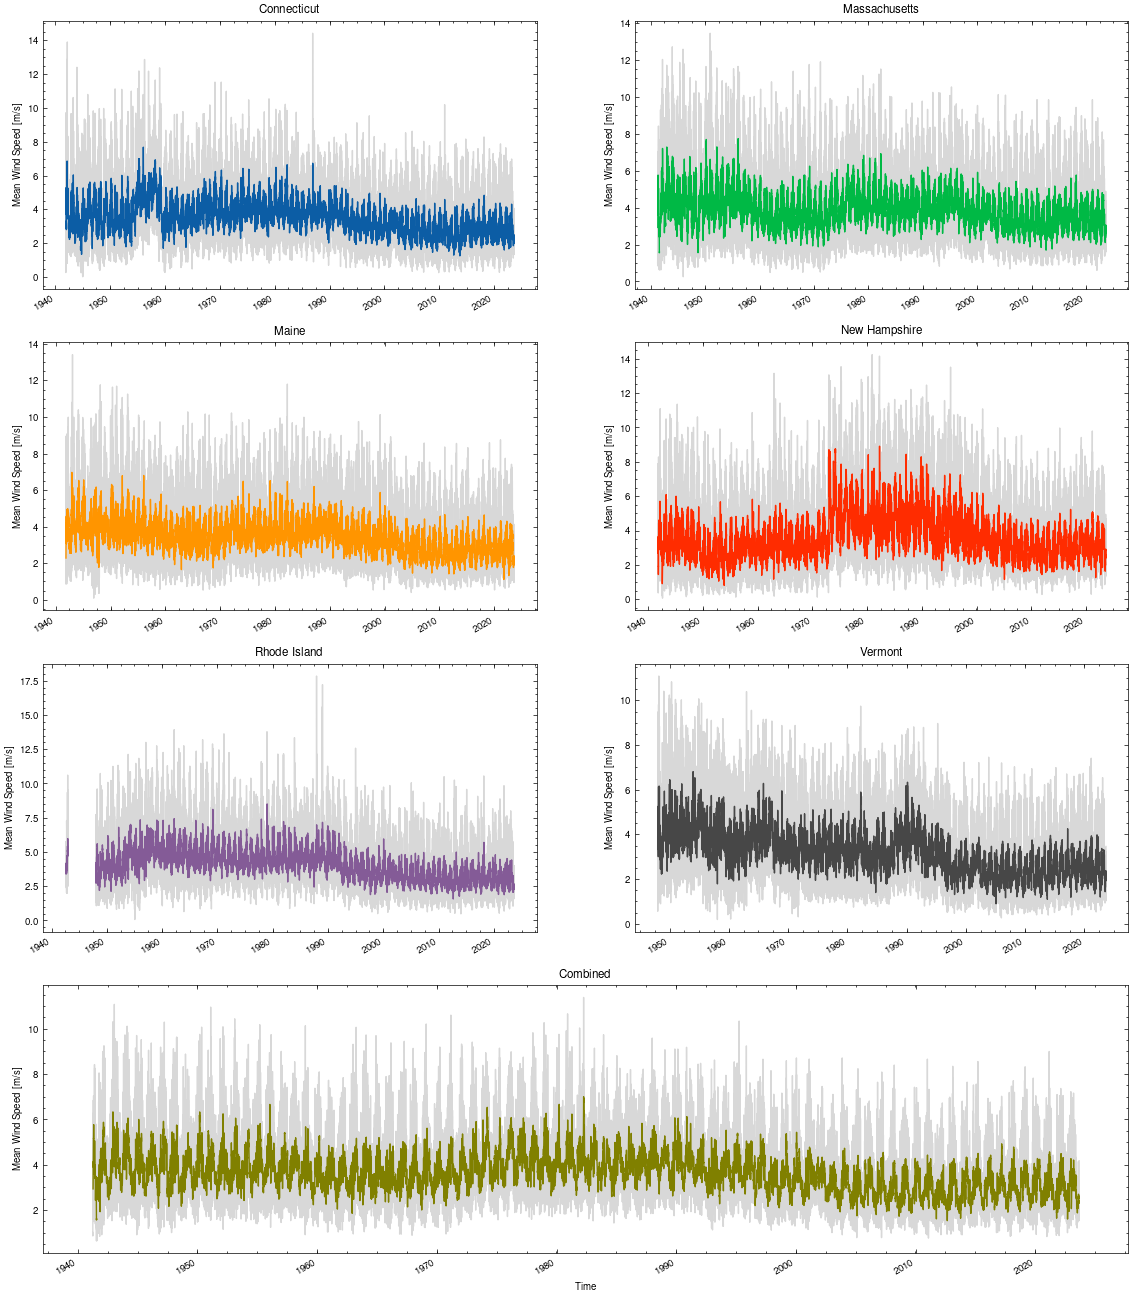

In [71]:
n_plots = len(states)+1
ncols = 2
nrows = int(np.ceil(n_plots/ncols))
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*7,nrows*4))
fig=plt.figure(figsize=(ncols*7,nrows*4))

gs=GridSpec(nrows, ncols) # 2 rows, 3 columns

# So each subplot has different color
colors = plt.rcParams["axes.prop_cycle"]()

# Get mean of all sites per state
for i, state in enumerate(state_ds.state):
    row = i//ncols
    col = i%ncols
    pax = fig.add_subplot(gs[row,col])
    # pax = ax.flatten()[i]
    state_means = state_ds.sel(state=state).mean(dim=["station_id"])
    state_roll = state_means.rolling(time=12).mean()
    state_means.windspeeds.plot(
        ax=pax, label="Monthly", alpha = 0.3, color="grey"
    )
    state_roll.windspeeds.plot(
        ax=pax, label="Annual", color=next(colors)["color"]
    )
    pax.set_title(state.values)
    # Remove x-label
    pax.set_xlabel("")
    pax.set_ylabel("Mean Wind Speed [m/s]")
    
# Add mean of all states
all_mean = state_ds.mean(dim=["station_id", "state"])
all_roll = all_mean.rolling(time=12).mean()#.resample(time="1Y").mean()#.rolling(time=36).mean()
# all_mean.windspeeds.plot(ax=ax, label="All NE", color="black")
# pax = ax.flatten()[-1]
pax = fig.add_subplot(gs[-1,:])
all_mean.windspeeds.plot(
    ax=pax, label="Monthly", alpha = 0.3, color="grey"
)
all_roll.windspeeds.plot(
    ax=pax, label="Annual", color="#808000"
)
pax.set_title("Combined")
# Add legend
# ax.legend()
# Add labels
pax.set_xlabel("Time")
pax.set_ylabel("Mean Wind Speed [m/s]")
plt.show()

## Plot of average wind speed over time (One Plot)

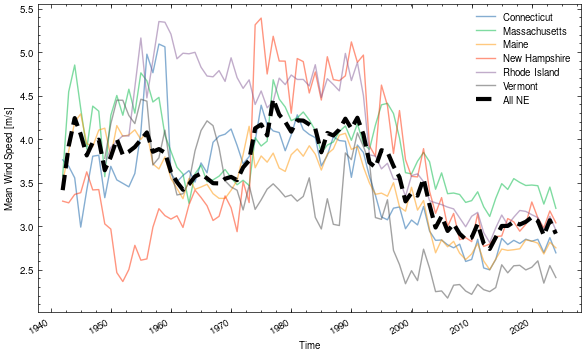

In [77]:
fig, ax = plt.subplots(figsize=(7,4))


# Get mean of all sites per state
for state in state_ds.state:
    state_means = state_ds.sel(state=state).mean(dim=["station_id"]).resample(time="1Y").mean()
    state_means["windspeeds"].plot(
        ax=ax, label=state.values, alpha=0.5
    )
    
# Add mean of all states
all_mean = state_ds.mean(dim=["station_id", "state"]).resample(time="1Y").mean()
all_mean["windspeeds"].plot(
    ax=ax, label="All NE", color="black", linewidth=3, linestyle="--"
)
# Add legend
ax.legend()
# Add labels
ax.set_xlabel("Time")
ax.set_ylabel("Mean Wind Speed [m/s]")
plt.show()